# Data Cube Coordinate Query

In [1]:
import os.path as op
import numpy as np
from astropy.table import Table

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

from astropy.wcs import WCS

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch


In [2]:
pdr_dir = '/home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/'
if not op.exists(pdr_dir):
    pdr_dir = '/home/jovyan/work/pdr1/'
    
ifu_data = Table.read(op.join( pdr_dir, 'ifu-index.fits'))

In [3]:
# Create SkyCoord Object array for IFU centers
ifu_coords = SkyCoord( ra=ifu_data['ra_cen']*u.deg, dec=ifu_data['dec_cen']*u.deg)

## This is an example of a big Lyman Alpha Blob at z=2.53

In [4]:
coord = SkyCoord(ra=228.78581*u.deg, dec=51.268036*u.deg)
wave_src = 4295.9 # angstrom

In [5]:
# find list of possible datacubes with coverage
sel = coord.separation( ifu_coords) < 26*u.arcsec

In [6]:
ifu_data[sel]

shotid,ifuslot,ra_cen,dec_cen,flag,flag_badamp,flag_badfib,flag_meteor,flag_satellite,flag_shot,flag_throughput,field,objid,date,obsid,ra_shot,dec_shot,pa,n_ifu,fwhm_virus,fwhm_virus_err,response_4540,ambtemp,datevobs,dewpoint,exptime,humidity,mjd,nstars_fit_fwhm,obsind,pressure,structaz,time,trajcdec,trajcpa,trajcra
int64,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes12,bytes18,int32,int32,float64,float64,float64,int32,float32,float32,float32,float32,bytes12,float32,float32,float32,float32,int32,int32,float32,float32,bytes7,float32,float32,float32
20180618017,024,228.79074,51.264973,1.0,1.0,1.0,1.0,1.0,1.0,1.0,dex-spring,HS00444d2_W,20180618,17,228.871039,51.349437,292.50071,40,1.4246124,0.16366434,0.1826,18.612223,20180618v017,9.869445,367.6003,55.798,58287.285,19,1,804.809,317.00266,0648106,51.3479,290.8775,228.87


### Collapse data cube to create a broad-band like and narrow-band like image

Here's an example of plotting up the Ly-alpha line flux for a bright LAB. We will generate a pseudo narrowband-like image at the wavelength of the Ly-alpha emission. We will also create a continuum like image to subtract from the line flux map.

In [7]:
shotid = ifu_data['shotid'][sel][0]
ifuslot= ifu_data['ifuslot'][sel][0]
datacube_path = op.join( pdr_dir, 'datacubes', str(shotid), 'dex_cube_{}_{}.fits'.format( shotid, ifuslot))

hdul = fits.open( datacube_path)

flux = hdul["DATA"].data
error = hdul["ERROR"].data
mask = hdul["MASK"].data

# apply mask using fill value 0.0
flux[ np.where(mask > 0) ] = np.nan

header = hdul["DATA"].header

wave = np.linspace( 3470, 5540, num=1036)

wcs = WCS(header)
    

In [8]:
# collapse at wavelength of known LAB 
z_index = np.abs( wave_src - wave) < 10    
# Slice the cube at the wavelength index

flux_nb = np.sum( flux[z_index, :, :], axis=0)
error_nb = np.sqrt( np.sum( error[z_index, :, :]**2, axis=0) )
    

Collapse the data cube from 3800 to 5500 Angstrom. This will make an image similar to a broad-band g-band image

In [9]:
z_index = (wave >= 3800) & (wave <= 5200)

flux_cont = np.sum( flux[z_index, :, :], axis=0)
error_cont = np.sqrt( np.sum( error[z_index, :, :]**2, axis=0) )
   

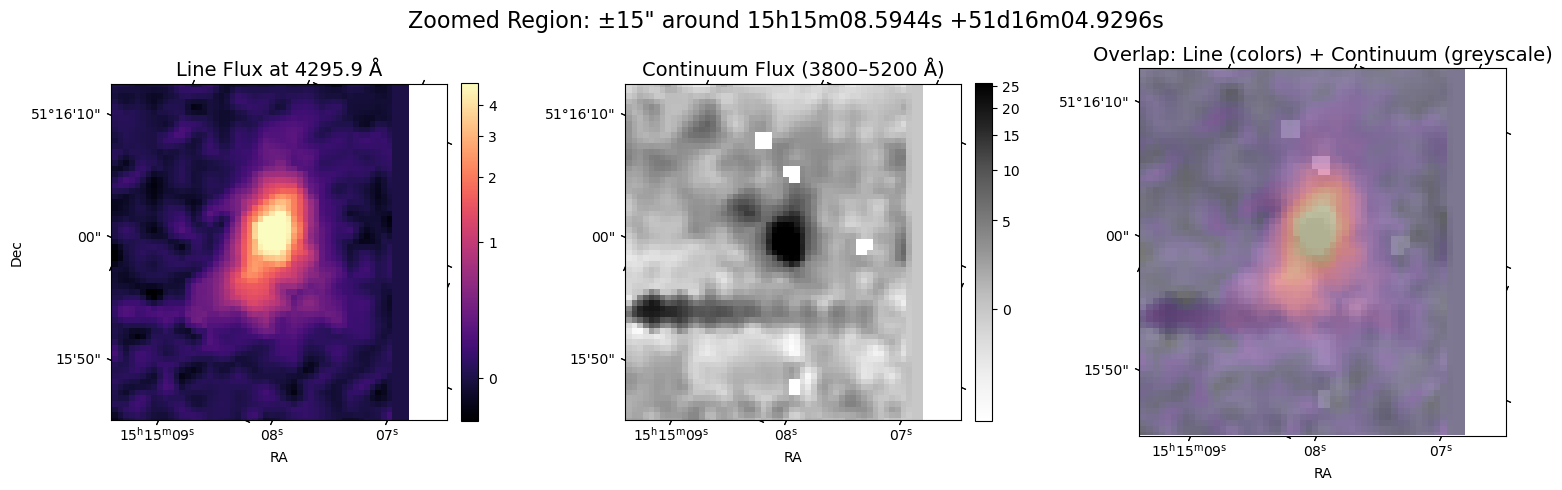

In [10]:
zoom_radius_arcsec = 15


# Convert center to pixel
x_center, y_center = wcs.celestial.world_to_pixel(coord)

# Convert zoom size in arcsec to pixels
arcsec_per_pixel = np.abs(wcs.wcs.cdelt[0]) * 3600  # assuming square pixels
half_width_pix = zoom_radius_arcsec / arcsec_per_pixel

interval = PercentileInterval(99.5)
vmin_nb, vmax_nb = interval.get_limits(flux_nb)
norm_nb = ImageNormalize(vmin=vmin_nb, vmax=vmax_nb, stretch=AsinhStretch())

vmin_cont, vmax_cont = interval.get_limits(flux_cont)
norm_cont = ImageNormalize(vmin=vmin_cont, vmax=vmax_cont, stretch=AsinhStretch())

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5), subplot_kw={'projection': wcs.celestial})
plt.subplots_adjust(wspace=0.4)

# Panel 1: Line flux
im0 = axes[0].imshow(flux_nb, origin='lower', cmap='magma', norm=norm_nb)
axes[0].set_title(f"Line Flux at {wave_src:.1f} Å", fontsize=14)
axes[0].coords[0].set_axislabel('RA')
axes[0].coords[1].set_axislabel('Dec')
axes[0].set_xlim(x_center - half_width_pix, x_center + half_width_pix)
axes[0].set_ylim(y_center - half_width_pix, y_center + half_width_pix)
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Panel 2: Continuum
im1 = axes[1].imshow(flux_cont, origin='lower', cmap='Greys', norm=norm_cont)
axes[1].set_title("Continuum Flux (3800–5200 Å)", fontsize=14)
axes[1].coords[0].set_axislabel('RA')
axes[1].coords[1].set_axislabel('')
axes[1].set_xlim(x_center - half_width_pix, x_center + half_width_pix)
axes[1].set_ylim(y_center - half_width_pix, y_center + half_width_pix)
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Panel 3: Overlap
axes[2].imshow(flux_cont, origin='lower', cmap='Greys', norm=norm_cont, alpha=0.6)
axes[2].imshow(flux_nb, origin='lower', cmap='magma', norm=norm_nb, alpha=0.5)
axes[2].set_title("Overlap: Line (colors) + Continuum (greyscale)", fontsize=14)
axes[2].coords[0].set_axislabel('RA')
axes[2].coords[1].set_axislabel('')
axes[2].set_xlim(x_center - half_width_pix, x_center + half_width_pix)
axes[2].set_ylim(y_center - half_width_pix, y_center + half_width_pix)

# Global title
plt.suptitle(f"Zoomed Region: ±{zoom_radius_arcsec}\" around {coord.to_string('hmsdms')}", fontsize=16)
plt.show()

## Example Three-color Map of a Nearby Emission-Line galaxy

In this example we will plot up a three color image of a low-redshift starforming galaxy that exhibit line emission at OII, abd OIII. We will make the three color maps using a combination of these two emission line maps and a continuum image. From the source catalog we know the galaxy is at z=

In [11]:
coord = SkyCoord(ra=215.68578*u.deg, dec=52.11736*u.deg)
redshift = 0.067

In [12]:
# find list of possible datacubes with coverage
sel = coord.separation( ifu_coords) < 26*u.arcsec

In [13]:
ifu_data[sel]

shotid,ifuslot,ra_cen,dec_cen,flag,flag_badamp,flag_badfib,flag_meteor,flag_satellite,flag_shot,flag_throughput,field,objid,date,obsid,ra_shot,dec_shot,pa,n_ifu,fwhm_virus,fwhm_virus_err,response_4540,ambtemp,datevobs,dewpoint,exptime,humidity,mjd,nstars_fit_fwhm,obsind,pressure,structaz,time,trajcdec,trajcpa,trajcra
int64,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes12,bytes18,int32,int32,float64,float64,float64,int32,float32,float32,float32,float32,bytes12,float32,float32,float32,float32,int32,int32,float32,float32,bytes7,float32,float32,float32
20190405020,034,215.68808,52.115025,1.0,1.0,1.0,1.0,1.0,1.0,1.0,dex-spring,DEXsp6210,20190405,20,215.707429,52.045023,68.823284,46,1.4450058,0.26003242,0.1634,15.331111,20190405v020,-7.733333,368.2825,16.498,58578.24,19,1,803.3867,41.27882,0541459,52.044964,67.28403,215.70683


In [14]:
shotid = ifu_data['shotid'][sel][0]
ifuslot= ifu_data['ifuslot'][sel][0]
datacube_path = op.join( pdr_dir, 'datacubes', str(shotid), 'dex_cube_{}_{}.fits'.format( shotid, ifuslot))

hdul = fits.open( datacube_path)

flux = hdul["DATA"].data
error = hdul["ERROR"].data
mask = hdul["MASK"].data

# apply mask using fill value 0.0
flux[ np.where(mask > 0) ] = 0.0

header = hdul["DATA"].header

wave = np.linspace( 3470, 5540, num=1036)

wcs = WCS(header)
    

In [15]:
# collapse along the full spectra dimension to get the continuum
wave_lo = 3800
wave_hi = 5500
z_index = (wave >= wave_lo) & (wave <= wave_hi)

flux_cont = np.sum( flux[ z_index, :, :], axis=0)

In [16]:
waveoii = 3727.8
waveoiii = 5008.24
dwave = 10 # 
z_index = np.abs( waveoii*(1.+redshift) - wave ) < dwave 
flux_oii = np.sum( flux[z_index, :, :], axis=0)

z_index = np.abs( waveoiii*(1.+redshift) - wave ) < dwave
flux_oiii = np.sum( flux[z_index, :, :], axis=0)

# to subtract out the contribution of the continuum from the emission
# line maps, need the relative spectral width ratio
dw_nb = 2*dwave
dw_cont = wave_hi - wave_lo
flux_cont_sub = dw_nb*(flux_cont/(dw_cont))

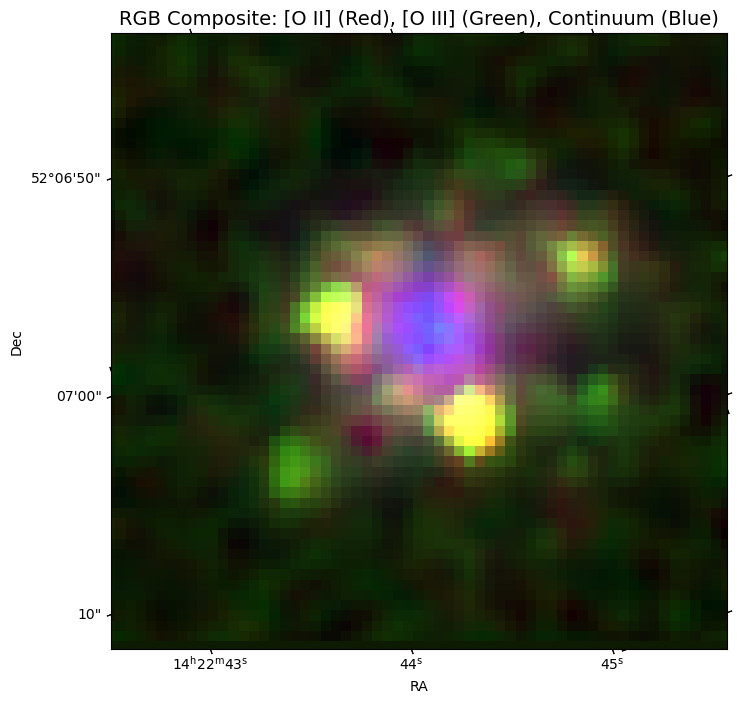

In [17]:
zoom_arcsec = 15

# Build the RGB layers
red   = flux_oii - flux_cont_sub
green = flux_oiii - flux_cont_sub
blue = flux_cont

# Normalize each using percentile-based scaling
interval = PercentileInterval(99.5)

r_scaled = interval(red)
g_scaled = interval(green)
b_scaled = interval(blue)

# Stack and clean
rgb_image = np.stack([r_scaled, g_scaled, b_scaled], axis=-1)
rgb_image = np.nan_to_num(rgb_image, nan=0.0)
rgb_image = np.clip(rgb_image, 0, 1)

# Convert zoom center to pixel
x_center, y_center = wcs.celestial.world_to_pixel(coord)

# Convert arcsec to pixels (assume square pixels)
pix_scale = np.abs(wcs.wcs.cdelt[0]) * 3600  # deg → arcsec
half_width_pix = zoom_arcsec / pix_scale

# Plot with WCS
fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': wcs.celestial})

ax.imshow(rgb_image, origin='lower')

# Zoom
ax.set_xlim(x_center - half_width_pix, x_center + half_width_pix)
ax.set_ylim(y_center - half_width_pix, y_center + half_width_pix)

# Labels
ax.set_title("RGB Composite: [O II] (Red), [O III] (Green), Continuum (Blue)", fontsize=14)
ax.coords[0].set_axislabel('RA')
ax.coords[1].set_axislabel('Dec')

plt.show()
